# Day 11 Analysis

Day 11 is a continuation of the analysis done on Day 10. Yesterday I found WRs under and overperforming expectation in terms of average PPR pts per week through Week 8 of the 2022 season.  

I also want to change the historical dataset slightly to be at the player-season level, specially averaging a player's first 8 weeks of each season they played in the NFL. This should give a more apples-to-apples comparison and a more accurate prediction of expected fantasy points.

## Set Up

In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. PPR Fantasy Points: 1999-2011
First I'll get the average target share and PPR fantasy points scored by WR for seasons 1999-2021. Then I'll fit a regression line to the data which will be used to generate expected PR fantasy points for the 2022 season.

### Get Data

In [67]:
query = """
WITH data AS (
    SELECT
        player_id,
        season,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
        AND week <= 8
), aggregation AS (
    SELECT
        player_name,
        season,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name, season
)
SELECT *
FROM aggregation
"""

df_by_player_season_1999_2021 = pd.read_sql(query, conn)
print(df_by_player_season_1999_2021.shape)
df_by_player_season_1999_2021.head()


(3829, 5)


,player_name,season,num_games,avg_tgt_share,avg_pts_ppr
0,Derrick Alexander,1999,7,0.225406,11.600000
1,Derrick Alexander,2000,6,0.273746,17.783333
2,Derrick Alexander,2001,5,0.201595,7.700000
3,Derrick Alexander,2002,7,0.130659,4.771429
4,Reidel Anthony,1999,6,0.187041,7.966667


### Clean Data

In [68]:
# Check for number of games played
# If number of game played = 1, can create noise. Will want to remove
print(df_by_player_season_1999_2021['num_games'].value_counts(normalize=True).sort_index())

df_by_player_season_1999_2021 = df_by_player_season_1999_2021[df_by_player_season_1999_2021['num_games'] > 1]
print(df_by_player_season_1999_2021.shape)

1    0.111517
2    0.097676
3    0.085140
4    0.077305
5    0.098459
6    0.129538
7    0.269522
8    0.130844
Name: num_games, dtype: float64
(3402, 5)


### Exploratory Analysis

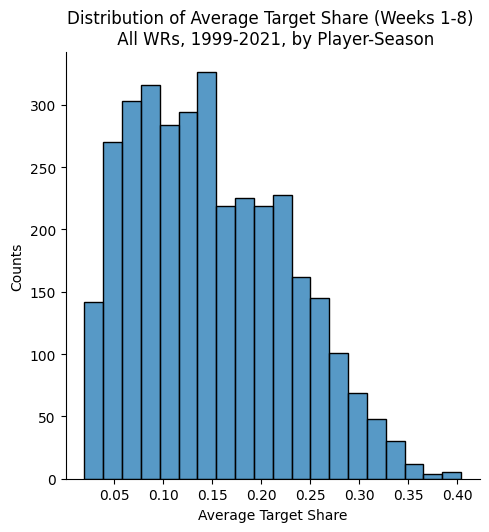

In [69]:
# Check distribution
g = sns.displot(
    x="avg_tgt_share",
    data=df_by_player_season_1999_2021,
    kind="hist",
    bins = 20
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Counts",
    title="Distribution of Average Target Share (Weeks 1-8) \n All WRs, 1999-2021, by Player-Season"
)

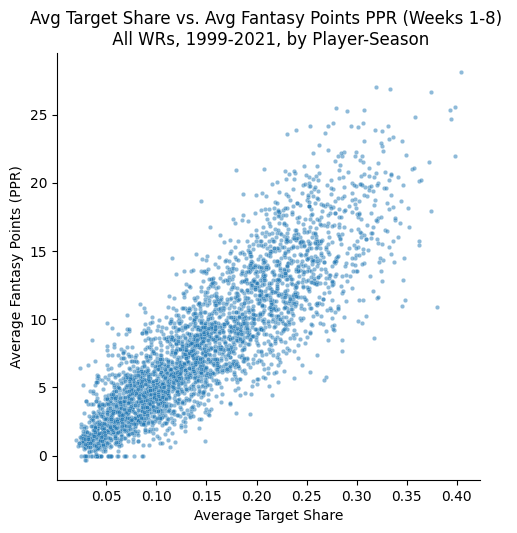

In [70]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_pts_ppr",
    data=df_by_player_season_1999_2021,
    alpha=0.5,
    s=10
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Points (PPR)",
    title="Avg Target Share vs. Avg Fantasy Points PPR (Weeks 1-8) \n All WRs, 1999-2021, by Player-Season"
)

In [71]:
print(f"Correlation Coefficient: {df_by_player_season_1999_2021['avg_tgt_share'].corr(df_by_player_season_1999_2021['avg_pts_ppr']).round(3)}")

Correlation Coefficient: 0.863


**Note**: The correlation coefficient is lower than yesterday when we were looking at historical data at the player-level. This makes sense as going to the player-season level is going to create more variation – some players are going to have very good or very bad starts to a season which can be uncharacteristic to their career-level stats. This means that the model predictions are going to be more varied as well.

### Run Regression

In [72]:
# Fit a regression line
fit = np.polyfit(
    x=df_by_player_season_1999_2021['avg_tgt_share'], 
    y=df_by_player_season_1999_2021['avg_pts_ppr'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [73]:
# Use regression equation to get expected fantasy points for the 2022 season

# Get data
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season = 2022
        AND week <= 8
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_2022 = pd.read_sql(query, conn)

# Create summary table
summary_2022 = df_by_player_2022.sort_values('avg_pts_ppr', ascending=False).reset_index(drop=True) # index = fantasy points ranking
summary_2022.index = summary_2022.index + 1 # easier to read (1 is now top player by avg fantasy points)

summary_2022 = summary_2022.sort_values('avg_tgt_share', ascending=False)

summary_2022['avg_pts_expected'] = lin_func_fpts(summary_2022['avg_tgt_share'])
summary_2022['avg_pts_diff'] = summary_2022['avg_pts_ppr'] - summary_2022['avg_pts_expected']

print(summary_2022.shape)
summary_2022.head(10).round(3)


(196, 6)


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
1,DeAndre Hopkins,2,0.393,27.100,22.436,4.664
20,CeeDee Lamb,8,0.328,14.600,18.668,-4.068
3,Cooper Kupp,7,0.325,24.529,18.489,6.039
4,Tyreek Hill,8,0.321,22.450,18.298,4.152
7,A.J. Brown,7,0.314,19.271,17.842,1.429
11,Davante Adams,7,0.297,17.014,16.854,0.160
34,D.J. Moore,8,0.290,12.175,16.498,-4.323
5,Justin Jefferson,7,0.290,21.203,16.490,4.713
2,Stefon Diggs,7,0.287,24.771,16.322,8.449
53,Drake London,8,0.280,9.825,15.909,-6.084


Based on the regression line fit on 1999-2021 player-season data, CeeDee Lamb is scoring 4 PPR fantasy points less than he should be, per week – a good candidate for positive regression given his extremely high target share. Stefon Diggs is scoring 8.5 PPR fantasy points more than he should be, per week – a good candidate for negative regression. He is scoring much more than would be expected given his target share.

To see how likely it is for a player to regress to the mean, I will look at the distribution of `avg_points_diff` and if normal, will use statistical methods to determine probability.

In [74]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
# Remove players with only 1 game played as that can be considered noise
bottom_5_2022 = summary_2022[summary_2022['num_games'] > 1] \
    .sort_values('avg_pts_diff', ascending=True) \
    .round(3)

pd.concat([bottom_5_2022.head(), bottom_5_2022[-5:]])

,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
76,Darnell Mooney,8,0.273,7.675,15.497,-7.822
53,Drake London,8,0.280,9.825,15.909,-6.084
109,Equanimeous St. Brown,7,0.196,5.271,11.021,-5.750
77,Robert Woods,7,0.231,7.657,13.034,-5.377
143,Marcus Johnson,4,0.143,3.075,7.926,-4.851
30,Jahan Dotson,4,0.132,13.050,7.253,5.797
9,Jaylen Waddle,8,0.217,18.050,12.218,5.832
3,Cooper Kupp,7,0.325,24.529,18.489,6.039
51,Rashid Shaheed,3,0.051,9.833,2.589,7.245
2,Stefon Diggs,7,0.287,24.771,16.322,8.449


Darnell Mooney is the standout here. With almost 27% of his team's target share in 2022 he's scoring about 7.8 standard fantasy points less per game than expected based on the observed relationship between target share and fantasy points. 

## Analyze Average Points Differential

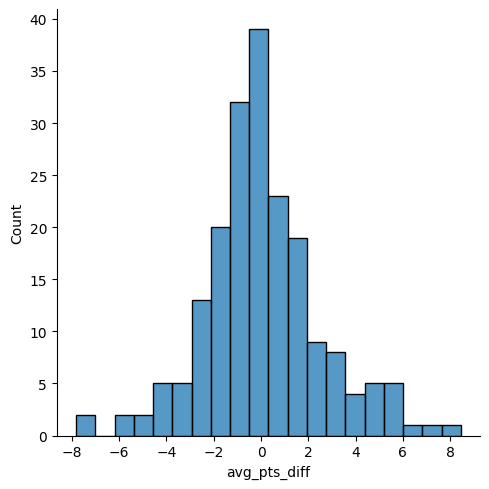

In [75]:
sns.displot(
    x='avg_pts_diff',
    data=summary_2022,
    kind="hist",
    bins=20
)

The distribution looks like a normal distribution with mean around 0. Next I'll get average points differential on the 1999-2021 population to confirm.

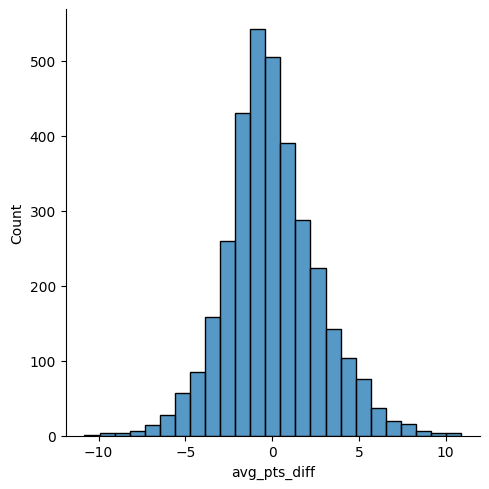

In [76]:
# Use regression line on original dataset with all values 
df_by_player_season_1999_2021['avg_pts_expected'] = lin_func_fpts(df_by_player_season_1999_2021['avg_tgt_share'])
df_by_player_season_1999_2021['avg_pts_diff'] = df_by_player_season_1999_2021['avg_pts_ppr'] - df_by_player_season_1999_2021['avg_pts_expected']

sns.displot(
    x='avg_pts_diff',
    data=df_by_player_season_1999_2021,
    kind="hist",
    bins=25
)

The population distribution confirms that average points differential is normally distributed with a mean of approximately 0.

In [77]:
summary_2022['avg_pts_diff'].describe()

count    196.000000
mean       0.027211
std        2.512060
min       -7.822288
25%       -1.316383
50%       -0.066556
75%        1.364527
max        8.449186
Name: avg_pts_diff, dtype: float64

In [78]:
df_by_player_season_1999_2021['avg_pts_diff'].describe().apply(lambda x: format(x, 'f'))

count    3402.000000
mean       -0.000000
std         2.646295
min       -10.809498
25%        -1.624465
50%        -0.205937
75%         1.498470
max        10.891564
Name: avg_pts_diff, dtype: object

The observed expected points differential from 1999-2021 is normally distributed with a mean of 0 and standard deviation of 2.65. Therefore we would expect the sample population of player averages for 2022 to be normally distributed as well and thus we should be able to compute the likelihood of a player finishing with that expected point differential (actual - expected) using statistical methods. 

In [79]:
def cdf_player_2022(df, df_current_season, player_name):
    """
    Return the probability of <= a player's expected point differential given:
    df: the dataset we want to get the probability from
    df_current_season: the dataset where we want to get a player's expected point differential
    player_name: name of player in df_current_season
    """
    cdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).cdf(df_current_season[df_current_season['player_name'] == player_name]['avg_pts_diff'])
    return round((cdf[0] * 100),2)

def pdf_player_2022(df, df_current_season, player_name):
    """
    Return the probability of a player's expected point differential given:
    df: the dataset we want to get the probability from
    df_current_season: the dataset where we want to get a player's expected point differential
    player_name: name of player in df_current_season
    """
    pdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).pdf(df_current_season[df_current_season['player_name'] == player_name]['avg_pts_diff'])
    return round((pdf[0] * 100),2)

The pdf function calculates the probability of X for a given value of X. In this case, we are looking at the probability of a player having an average points differential of X for a given value of X (target share).

In [80]:
pdf_player_2022(summary_2022, 'CeeDee Lamb')

TypeError: pdf_player_2022() missing 1 required positional argument: 'player_name'

Going back to CeeDee lamb, using the normal distribution of average points differential, we are able to calculate that there is a 4.2% chance of scoring 4 points less than expected per week given his nearly 33% target share. If this is the case, CeeDee is a great "buy low", positive regression candidate and should be due for a more productive second half of the season.

In [ ]:
# Show the average points outperformers 
top_tgt_share_1999_2021 = df_by_player_season_1999_2021.sort_values('avg_tgt_share', ascending=False).reset_index(drop=True)
top_tgt_share_1999_2021.index = top_tgt_share_1999_2021.index + 1

print("Historical Data: 1999 - 2021")
top_tgt_share_1999_2021[top_tgt_share_1999_2021['num_games'] > 1] \
    .sort_values('avg_pts_diff', ascending=False) \
    .round(3) \
    .head(10)

Historical Data: 1999 - 2021


,player_name,season,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
1174,Will Fuller,2017,4,0.180,20.950,10.058,10.892
1620,Martavis Bryant,2014,2,0.145,18.650,8.035,10.615
589,Isaac Bruce,2000,7,0.230,23.586,12.996,10.589
499,Randy Moss,2007,8,0.239,23.863,13.527,10.336
385,Calvin Johnson,2011,8,0.253,24.175,14.344,9.831
211,Torry Holt,2003,7,0.279,25.471,15.835,9.636
845,Austin Collie,2010,6,0.207,21.017,11.666,9.351
73,Davante Adams,2020,5,0.319,27.040,18.185,8.855
256,Calvin Johnson,2013,7,0.272,24.157,15.405,8.752
163,Adam Thielen,2018,8,0.291,25.250,16.508,8.742


In [ ]:
print("Historical Data: 1999 - 2021")
top_tgt_share_1999_2021[top_tgt_share_1999_2021['player_name'] == 'Stefon Diggs'] \
    .round(3) \
    .head(10)

Historical Data: 1999 - 2021


,player_name,season,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
121,Stefon Diggs,2015,4,0.303,19.950,17.238,2.712
124,Stefon Diggs,2020,8,0.303,17.688,17.210,0.478
341,Stefon Diggs,2016,6,0.259,15.567,14.645,0.922
401,Stefon Diggs,2018,8,0.252,18.288,14.262,4.025
409,Stefon Diggs,2021,7,0.251,15.757,14.208,1.549
483,Stefon Diggs,2019,8,0.241,15.925,13.600,2.325
837,Stefon Diggs,2017,6,0.208,15.483,11.700,3.783


In [ ]:
print("Current 2022 Season: Stefon Diggs")
summary_2022[summary_2022['player_name'] == 'Stefon Diggs'] \
    .head(10) \
    .round(3)

Current 2022 Season: Stefon Diggs


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
2,Stefon Diggs,7,0.287,24.771,16.322,8.449


In [ ]:
# Number of seasons with at least 1 player scoring 8 PPR pts above expectation, on average, through Weeks 1-8
# and percentage of total individual seasons in the dataset
num_seasons = len(top_tgt_share_1999_2021[top_tgt_share_1999_2021['avg_pts_diff'] >= 8]['season'].unique())
print(num_seasons)
print(round(num_seasons/(2021-1999),2))


13
0.59


In [ ]:
pdf_player_2022(df_by_player_season_1999_2021, summary_2022, "Stefon Diggs")

0.09

Looking at historical data, we've seen hot starts like this before. In fact, for 13 out of the 21 previous seasons, there was at least one player who was scoring at least 8 PPR pts above expectation, on average, through Week 8. However, it's still really rare – based on the distribution of the historical data, we would expect to see Digg's 2022 expected points differential only 0.09% of the time. That's extremely unlikely!

Also, Diggs is performing way better than usual! His previous best start was 4 PPR pts above expectation – 50% less than what he's currently achieving. His 2022 season so far is truly remarkable but I'm not so sure he'll be able to keep this up.

Moving forward I'd like to compare players' first 8 games to their last 8 games and see how common it is to keep up such high production.